In [1]:
import re
import sys
from time import sleep
from pprint import pprint
from functools import partial

import numpy as np
import optuna
try:
    import pandas as pd
except:
    pass


FILENAME = "main.cpp"

In [2]:
#!cp ../exp012_Dlarge_M2/main.cpp ./

In [3]:
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out

main.cpp:458: warning: ignoring #pragma warning  [-Wunknown-pragmas]
  458 | #pragma warning( disable : 4146 )
      | 
main.cpp: In member function ‘void UltimateEstimator::Step()’:
main.cpp:1149:39: warning: comparison of integer expressions of different signedness: ‘signed char’ and ‘std::array<double, 60>::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
 1149 |   for (auto col = (signed char)0; col < data_x.size(); col++) {
      |                                   ~~~~^~~~~~~~~~~~~~~
main.cpp:1107:8: warning: unused variable ‘estimated_distance’ [-Wunused-variable]
 1107 |   auto estimated_distance = 0.0;
      |        ^~~~~~~~~~~~~~~~~~
main.cpp: In member function ‘void Explorer::Step()’:
main.cpp:1465:30: warning: narrowing conversion of ‘(((int)v.Explorer::Node::y) + 1)’ from ‘int’ to ‘signed char’ [-Wnarrowing]
 1465 |     const auto u = Node{ v.y + (i8)1, v.x, false };
      |                          ~~~~^~~~~~~
main.cpp:1478:35: warning: narrowing conversion of ‘(((

In [2]:
%%time
# もとのスコアの確認
scores = []
for i in range(200):
    i = f"{i:03d}"
    score = !cargo run --release --manifest-path ../tools/Cargo.toml --bin tester in/{i}.txt $(pwd)/{FILENAME}.out 2>&1 | grep Score
    print(i, *score)
    score = int(score[0].split()[-1])
    scores.append(score)
np.mean(scores) / 1e6, np.std(scores) / 1e6

000 Score = 977756496
001 Score = 977649555
002 Score = 972745766
003 Score = 981337621
004 Score = 966981491
005 Score = 977432767
006 Score = 977921671
007 Score = 977673063
008 Score = 954265393
009 Score = 980760062
010 Score = 975371751
011 Score = 977438794
012 Score = 974924531
013 Score = 975237745
014 Score = 968989685
015 Score = 975958242
016 Score = 980018113
017 Score = 964984235
018 Score = 966526857
019 Score = 976594881
020 Score = 972741349
021 Score = 977577664
022 Score = 963759570
023 Score = 976314983
024 Score = 966475179
025 Score = 968360005
026 Score = 967249892
027 Score = 973841651
028 Score = 976048814
029 Score = 974816678
030 Score = 967348765
031 Score = 978748481
032 Score = 969984390
033 Score = 977487840
034 Score = 969381555
035 Score = 969558774
036 Score = 974887453
037 Score = 946287538
038 Score = 968794442
039 Score = 964051820
040 Score = 972207002
041 Score = 967330257
042 Score = 968237267
043 Score = 983238540
044 Score = 973508536
045 Score 

(971.29352379, 6.95158369191706)

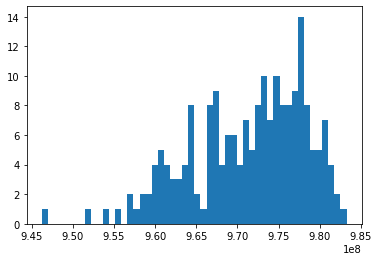

In [3]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.show()

In [2]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

3 variables were found.


,name,method,min,max,log,left,right
0,LAMBDA,suggest_float,2.0,10000.0,True,constexpr double LAMBDA =,"; // OPTIMIZE [2.0, 1e4] LOG"
1,LASSO_LAMBDA,suggest_float,1000.0,1000000.0,True,constexpr double LASSO_LAMBDA =,"; // OPTIMIZE [1e3, 1e6] LOG"
2,RIDGE2_LAMBDA,suggest_float,1.0,10000000.0,True,constexpr double RIDGE2_LAMBDA =,"; // OPTIMIZE [1.0, 1e7] LOG"


In [3]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 10  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out
    !mkdir {index_parallel}_score
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {directory_input}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read())
    return sum_score

In [4]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 10
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=2, callbacks=[callback])

[I 2021-05-30 02:27:29,008] Using an existing study with name 'study' instead of creating a new one.
/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.935592249630442;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 566593.9019794503;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.624305235866693;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/con

[I 2021-05-30 02:29:18,087] Trial 272 finished with value: 194967829145.0 and parameters: {'LAMBDA': 14.705040515280475, 'LASSO_LAMBDA': 584817.5021772209, 'RIDGE2_LAMBDA': 28.345378877636737}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists


[I 2021-05-30 02:29:18,417] Trial 273 finished with value: 195000071834.0 and parameters: {'LAMBDA': 14.935592249630442, 'LASSO_LAMBDA': 566593.9019794503, 'RIDGE2_LAMBDA': 28.624305235866693}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
rm: cannot remove '4_out/*': No such file or directory
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.541831252567077;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 406689.9570947343;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 47.114618478091906;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.7583323

[I 2021-05-30 02:31:01,169] Trial 274 finished with value: 194910038241.0 and parameters: {'LAMBDA': 11.541831252567077, 'LASSO_LAMBDA': 406689.9570947343, 'RIDGE2_LAMBDA': 47.114618478091906}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory


[I 2021-05-30 02:31:01,550] Trial 275 finished with value: 194530396607.0 and parameters: {'LAMBDA': 11.758332363604532, 'LASSO_LAMBDA': 325611.7823036167, 'RIDGE2_LAMBDA': 19.613836731905113}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.97430746053567;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 494366.28576340876;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.502558170323178;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 331.0855054520303;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's

[I 2021-05-30 02:32:36,335] Trial 276 finished with value: 194894406051.0 and parameters: {'LAMBDA': 16.97430746053567, 'LASSO_LAMBDA': 494366.28576340876, 'RIDGE2_LAMBDA': 11.502558170323178}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.120709863754104;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 397528.9923729898;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 6.9534068723877605;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:32:37,978] Trial 277 finished with value: 193671965324.0 and parameters: {'LAMBDA': 331.0855054520303, 'LASSO_LAMBDA': 490357.35469231306, 'RIDGE2_LAMBDA': 11.343077752905124}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.333513168882574;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 371856.6000566611;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 7.067052760442348;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:34:14,366] Trial 278 finished with value: 194599522233.0 and parameters: {'LAMBDA': 8.120709863754104, 'LASSO_LAMBDA': 397528.9923729898, 'RIDGE2_LAMBDA': 6.9534068723877605}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.851590006228284;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 5294.372430561662;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.3395094558035;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:34:16,019] Trial 279 finished with value: 194638799565.0 and parameters: {'LAMBDA': 8.333513168882574, 'LASSO_LAMBDA': 371856.6000566611, 'RIDGE2_LAMBDA': 7.067052760442348}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.215475575419571;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 617997.1454446453;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.74486307332558;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:35:54,224] Trial 281 finished with value: 194964952229.0 and parameters: {'LAMBDA': 10.215475575419571, 'LASSO_LAMBDA': 617997.1454446453, 'RIDGE2_LAMBDA': 22.74486307332558}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.61959290878197;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 573612.2160988792;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 33.29354394918449;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:36:07,622] Trial 280 finished with value: 187266471335.0 and parameters: {'LAMBDA': 9.851590006228284, 'LASSO_LAMBDA': 5294.372430561662, 'RIDGE2_LAMBDA': 37.3395094558035}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.250818924801727;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 577269.06147794;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.529105297431173;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:37:29,917] Trial 282 finished with value: 194940160521.0 and parameters: {'LAMBDA': 17.61959290878197, 'LASSO_LAMBDA': 573612.2160988792, 'RIDGE2_LAMBDA': 33.29354394918449}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.842316830764146;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 438596.89790646976;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.073221159752139;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:37:44,006] Trial 283 finished with value: 194987776621.0 and parameters: {'LAMBDA': 18.250818924801727, 'LASSO_LAMBDA': 577269.06147794, 'RIDGE2_LAMBDA': 15.529105297431173}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.637553299077961;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 442331.0832292139;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.39834187357399;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:39:04,296] Trial 284 finished with value: 194996843172.0 and parameters: {'LAMBDA': 12.842316830764146, 'LASSO_LAMBDA': 438596.89790646976, 'RIDGE2_LAMBDA': 15.073221159752139}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.292116996401043;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 275121.53497992584;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.73005957426526;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:39:20,216] Trial 285 finished with value: 195003008883.0 and parameters: {'LAMBDA': 13.637553299077961, 'LASSO_LAMBDA': 442331.0832292139, 'RIDGE2_LAMBDA': 22.39834187357399}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.569702281680883;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 319661.63461077446;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 54.18020544520516;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:40:38,198] Trial 286 finished with value: 194984598952.0 and parameters: {'LAMBDA': 14.292116996401043, 'LASSO_LAMBDA': 275121.53497992584, 'RIDGE2_LAMBDA': 22.73005957426526}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.452136620396493;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 518642.70503344864;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 59.011088459371855;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:40:53,506] Trial 287 finished with value: 194865783973.0 and parameters: {'LAMBDA': 14.569702281680883, 'LASSO_LAMBDA': 319661.63461077446, 'RIDGE2_LAMBDA': 54.18020544520516}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.622444012845573;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 514416.2424005152;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2052.8649528778697;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:42:13,562] Trial 288 finished with value: 194834241403.0 and parameters: {'LAMBDA': 11.452136620396493, 'LASSO_LAMBDA': 518642.70503344864, 'RIDGE2_LAMBDA': 59.011088459371855}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.481029732033953;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 644578.9716852283;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.20187646538845;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:42:27,879] Trial 289 finished with value: 193859578234.0 and parameters: {'LAMBDA': 11.622444012845573, 'LASSO_LAMBDA': 514416.2424005152, 'RIDGE2_LAMBDA': 2052.8649528778697}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.022342960332285;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 625676.7110712263;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.15915436018697;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:43:50,121] Trial 290 finished with value: 194991020658.0 and parameters: {'LAMBDA': 17.481029732033953, 'LASSO_LAMBDA': 644578.9716852283, 'RIDGE2_LAMBDA': 16.20187646538845}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.96409573270926;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 372726.8881376367;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.583836660031672;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:44:02,830] Trial 291 finished with value: 195021865833.0 and parameters: {'LAMBDA': 17.022342960332285, 'LASSO_LAMBDA': 625676.7110712263, 'RIDGE2_LAMBDA': 17.15915436018697}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.63206328966983;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 626800.2628541286;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.359648813956062;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:25,606] Trial 292 finished with value: 194983419318.0 and parameters: {'LAMBDA': 15.96409573270926, 'LASSO_LAMBDA': 372726.8881376367, 'RIDGE2_LAMBDA': 31.583836660031672}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.549727752500427;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 544893.8108847594;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.359578388330803;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:38,011] Trial 293 finished with value: 194764567633.0 and parameters: {'LAMBDA': 16.63206328966983, 'LASSO_LAMBDA': 626800.2628541286, 'RIDGE2_LAMBDA': 9.359648813956062}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.050989479751312;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 625848.1446349272;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.097016045353694;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:47:00,186] Trial 294 finished with value: 194772478619.0 and parameters: {'LAMBDA': 18.549727752500427, 'LASSO_LAMBDA': 544893.8108847594, 'RIDGE2_LAMBDA': 9.359578388330803}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 656.1865037552761;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 654365.3987136711;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.73877861037832;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:47:11,936] Trial 295 finished with value: 194981691886.0 and parameters: {'LAMBDA': 19.050989479751312, 'LASSO_LAMBDA': 625848.1446349272, 'RIDGE2_LAMBDA': 13.097016045353694}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.235361080453307;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 406092.25639588694;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.62140382533533;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:48:36,761] Trial 296 finished with value: 193116463192.0 and parameters: {'LAMBDA': 656.1865037552761, 'LASSO_LAMBDA': 654365.3987136711, 'RIDGE2_LAMBDA': 13.73877861037832}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.922144274107724;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 417754.6956652781;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.671672994144995;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:48:47,071] Trial 297 finished with value: 194996671307.0 and parameters: {'LAMBDA': 14.235361080453307, 'LASSO_LAMBDA': 406092.25639588694, 'RIDGE2_LAMBDA': 17.62140382533533}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.205874455500943;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 452376.31154431077;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 29.02231009020086;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:50:11,257] Trial 298 finished with value: 195023524776.0 and parameters: {'LAMBDA': 13.922144274107724, 'LASSO_LAMBDA': 417754.6956652781, 'RIDGE2_LAMBDA': 18.671672994144995}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.65080151269611;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 436650.5462550959;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.05511172055913;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:50:22,213] Trial 299 finished with value: 194908266527.0 and parameters: {'LAMBDA': 9.205874455500943, 'LASSO_LAMBDA': 452376.31154431077, 'RIDGE2_LAMBDA': 29.02231009020086}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.626277477249499;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 337974.01659565995;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 43.82824419327653;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:44,441] Trial 300 finished with value: 194948431026.0 and parameters: {'LAMBDA': 9.65080151269611, 'LASSO_LAMBDA': 436650.5462550959, 'RIDGE2_LAMBDA': 28.05511172055913}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.168054858937598;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 341409.91205828876;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 39.82227897799019;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:56,149] Trial 301 finished with value: 194866549102.0 and parameters: {'LAMBDA': 12.626277477249499, 'LASSO_LAMBDA': 337974.01659565995, 'RIDGE2_LAMBDA': 43.82824419327653}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.8169705499756;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 381358.4850851023;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.453756494257888;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:53:19,158] Trial 302 finished with value: 194912337382.0 and parameters: {'LAMBDA': 12.168054858937598, 'LASSO_LAMBDA': 341409.91205828876, 'RIDGE2_LAMBDA': 39.82227897799019}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.83826181117463;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 511158.86861512536;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.15648923842697;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:53:31,530] Trial 303 finished with value: 194644019309.0 and parameters: {'LAMBDA': 10.8169705499756, 'LASSO_LAMBDA': 381358.4850851023, 'RIDGE2_LAMBDA': 20.453756494257888}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.576772881352852;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 517551.1225505768;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.03629966701633;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:54:54,618] Trial 304 finished with value: 194897824266.0 and parameters: {'LAMBDA': 6.83826181117463, 'LASSO_LAMBDA': 511158.86861512536, 'RIDGE2_LAMBDA': 19.15648923842697}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.520058873529969;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 568292.3488652207;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.799997928553372;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:55:07,100] Trial 305 finished with value: 195012975934.0 and parameters: {'LAMBDA': 14.576772881352852, 'LASSO_LAMBDA': 517551.1225505768, 'RIDGE2_LAMBDA': 17.03629966701633}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.280623683470047;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 433374.8203416006;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.10273680052349;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:56:30,652] Trial 306 finished with value: 194926262757.0 and parameters: {'LAMBDA': 14.520058873529969, 'LASSO_LAMBDA': 568292.3488652207, 'RIDGE2_LAMBDA': 12.799997928553372}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.097729799347958;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 431678.80117386807;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.50878482049325;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:56:42,863] Trial 307 finished with value: 194896480912.0 and parameters: {'LAMBDA': 14.280623683470047, 'LASSO_LAMBDA': 433374.8203416006, 'RIDGE2_LAMBDA': 11.10273680052349}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.830842773818205;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 486722.2688901707;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.363525483712827;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:58:06,438] Trial 308 finished with value: 194998081650.0 and parameters: {'LAMBDA': 14.097729799347958, 'LASSO_LAMBDA': 431678.80117386807, 'RIDGE2_LAMBDA': 16.50878482049325}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.155680987179483;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 288787.4263665376;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.78814111420318;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:58:18,572] Trial 309 finished with value: 194952067903.0 and parameters: {'LAMBDA': 9.830842773818205, 'LASSO_LAMBDA': 486722.2688901707, 'RIDGE2_LAMBDA': 16.363525483712827}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.125408806887894;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 286462.4330702981;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 116223.25550628576;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:40,637] Trial 310 finished with value: 194956165764.0 and parameters: {'LAMBDA': 10.155680987179483, 'LASSO_LAMBDA': 288787.4263665376, 'RIDGE2_LAMBDA': 17.78814111420318}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.99656723890536;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 392417.85477812175;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1.5645513976535317;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:52,303] Trial 311 finished with value: 193892191742.0 and parameters: {'LAMBDA': 11.125408806887894, 'LASSO_LAMBDA': 286462.4330702981, 'RIDGE2_LAMBDA': 116223.25550628576}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.847932196561047;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 501846.1545015292;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.151827982998501;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:01:17,991] Trial 312 finished with value: 192593138474.0 and parameters: {'LAMBDA': 7.99656723890536, 'LASSO_LAMBDA': 392417.85477812175, 'RIDGE2_LAMBDA': 1.5645513976535317}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.753418663986022;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 498235.6398272267;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.75438048605666;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:01:28,047] Trial 313 finished with value: 194656132959.0 and parameters: {'LAMBDA': 12.847932196561047, 'LASSO_LAMBDA': 501846.1545015292, 'RIDGE2_LAMBDA': 8.151827982998501}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.987149771754929;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 649347.4007190113;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 25.84129191381217;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:02:52,264] Trial 314 finished with value: 194743216474.0 and parameters: {'LAMBDA': 12.753418663986022, 'LASSO_LAMBDA': 498235.6398272267, 'RIDGE2_LAMBDA': 8.75438048605666}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 21.361202002039768;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 650442.3835075446;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 477.7498257813609;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:03:01,837] Trial 315 finished with value: 194995255821.0 and parameters: {'LAMBDA': 15.987149771754929, 'LASSO_LAMBDA': 649347.4007190113, 'RIDGE2_LAMBDA': 25.84129191381217}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 21.515696628306852;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 581338.5282157679;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.119127300558233;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:26,037] Trial 316 finished with value: 194020521374.0 and parameters: {'LAMBDA': 21.361202002039768, 'LASSO_LAMBDA': 650442.3835075446, 'RIDGE2_LAMBDA': 477.7498257813609}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.71001076759853;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 565833.1463327783;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.50126599785505;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:36,449] Trial 317 finished with value: 194985613180.0 and parameters: {'LAMBDA': 21.515696628306852, 'LASSO_LAMBDA': 581338.5282157679, 'RIDGE2_LAMBDA': 23.119127300558233}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.687370890773183;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 358734.24808870646;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.57335270599147;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:06:01,349] Trial 318 finished with value: 194956452713.0 and parameters: {'LAMBDA': 15.71001076759853, 'LASSO_LAMBDA': 565833.1463327783, 'RIDGE2_LAMBDA': 36.50126599785505}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.77347560181863;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 367261.84861245326;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 5.974579263525495;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:06:11,145] Trial 319 finished with value: 194949205595.0 and parameters: {'LAMBDA': 15.687370890773183, 'LASSO_LAMBDA': 358734.24808870646, 'RIDGE2_LAMBDA': 36.57335270599147}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.507841716898678;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 452219.5424828866;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.67289861938313;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:37,230] Trial 320 finished with value: 194466419608.0 and parameters: {'LAMBDA': 10.77347560181863, 'LASSO_LAMBDA': 367261.84861245326, 'RIDGE2_LAMBDA': 5.974579263525495}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.071278098256986;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 444966.30628111423;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.34853857267531;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:44,345] Trial 321 finished with value: 194738421251.0 and parameters: {'LAMBDA': 11.507841716898678, 'LASSO_LAMBDA': 452219.5424828866, 'RIDGE2_LAMBDA': 12.67289861938313}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.52343832071113;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 502899.01165742875;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.5820057675866;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:09:11,917] Trial 322 finished with value: 194868469400.0 and parameters: {'LAMBDA': 9.071278098256986, 'LASSO_LAMBDA': 444966.30628111423, 'RIDGE2_LAMBDA': 13.34853857267531}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.142135874476832;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 524098.66712946247;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.314503504061324;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:09:18,850] Trial 323 finished with value: 194922030922.0 and parameters: {'LAMBDA': 8.52343832071113, 'LASSO_LAMBDA': 502899.01165742875, 'RIDGE2_LAMBDA': 21.5820057675866}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.998330290719748;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 666775.7763575809;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 25.898372526702182;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:10:51,612] Trial 324 finished with value: 195019694432.0 and parameters: {'LAMBDA': 13.142135874476832, 'LASSO_LAMBDA': 524098.66712946247, 'RIDGE2_LAMBDA': 20.314503504061324}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.091830397088426;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 697006.9329926596;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.890257639776642;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:11:00,034] Trial 325 finished with value: 194999293238.0 and parameters: {'LAMBDA': 12.998330290719748, 'LASSO_LAMBDA': 666775.7763575809, 'RIDGE2_LAMBDA': 25.898372526702182}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.442388651226704;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 582782.1621532105;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.7606947659157;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:38,029] Trial 326 finished with value: 194983316478.0 and parameters: {'LAMBDA': 19.091830397088426, 'LASSO_LAMBDA': 697006.9329926596, 'RIDGE2_LAMBDA': 17.890257639776642}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.051935375133997;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 569881.4253217137;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.896068337370723;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:47,367] Trial 327 finished with value: 195011645576.0 and parameters: {'LAMBDA': 18.442388651226704, 'LASSO_LAMBDA': 582782.1621532105, 'RIDGE2_LAMBDA': 16.7606947659157}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 22.74334622836926;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 541905.352772632;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.288667493401027;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:25,722] Trial 328 finished with value: 194847957632.0 and parameters: {'LAMBDA': 17.051935375133997, 'LASSO_LAMBDA': 569881.4253217137, 'RIDGE2_LAMBDA': 10.896068337370723}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.285835885164772;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 399106.88184609084;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.796632263563186;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:34,774] Trial 329 finished with value: 194746198021.0 and parameters: {'LAMBDA': 22.74334622836926, 'LASSO_LAMBDA': 541905.352772632, 'RIDGE2_LAMBDA': 9.288667493401027}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 2.2509470495242088;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 409983.2798096718;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.206614579049253;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:16:13,351] Trial 330 finished with value: 194939072119.0 and parameters: {'LAMBDA': 20.285835885164772, 'LASSO_LAMBDA': 399106.88184609084, 'RIDGE2_LAMBDA': 14.796632263563186}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.31721562497225;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 510474.1733876825;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 33.13309752177192;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:16:23,085] Trial 331 finished with value: 194565735708.0 and parameters: {'LAMBDA': 2.2509470495242088, 'LASSO_LAMBDA': 409983.2798096718, 'RIDGE2_LAMBDA': 15.206614579049253}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 24.629774941726907;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 510836.4754664284;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.787397795453902;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:17:52,506] Trial 332 finished with value: 194914052063.0 and parameters: {'LAMBDA': 25.31721562497225, 'LASSO_LAMBDA': 510474.1733876825, 'RIDGE2_LAMBDA': 33.13309752177192}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.103016345011387;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 330315.97404184676;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.843298246041606;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:18:00,981] Trial 333 finished with value: 194961961867.0 and parameters: {'LAMBDA': 24.629774941726907, 'LASSO_LAMBDA': 510836.4754664284, 'RIDGE2_LAMBDA': 31.787397795453902}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.848748460708286;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 336772.30968992796;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 49.566873693018024;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:28,662] Trial 334 finished with value: 195018496409.0 and parameters: {'LAMBDA': 16.103016345011387, 'LASSO_LAMBDA': 330315.97404184676, 'RIDGE2_LAMBDA': 19.843298246041606}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.890418212935987;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 344756.9559075588;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.155373636865372;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:37,553] Trial 335 finished with value: 194863601465.0 and parameters: {'LAMBDA': 15.848748460708286, 'LASSO_LAMBDA': 336772.30968992796, 'RIDGE2_LAMBDA': 49.566873693018024}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.603273721773437;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 322766.5568520083;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.940092340862758;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:21:05,789] Trial 336 finished with value: 194845521754.0 and parameters: {'LAMBDA': 17.890418212935987, 'LASSO_LAMBDA': 344756.9559075588, 'RIDGE2_LAMBDA': 11.155373636865372}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.430653391111509;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 400627.0891588084;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.231138954876624;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:21:14,666] Trial 337 finished with value: 194849479721.0 and parameters: {'LAMBDA': 18.603273721773437, 'LASSO_LAMBDA': 322766.5568520083, 'RIDGE2_LAMBDA': 10.940092340862758}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 75.93973511576567;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 404750.2729494722;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.855797786226926;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:41,789] Trial 338 finished with value: 194996900391.0 and parameters: {'LAMBDA': 15.430653391111509, 'LASSO_LAMBDA': 400627.0891588084, 'RIDGE2_LAMBDA': 18.231138954876624}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.982380598471186;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 401864.94431722426;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 5.921411655509175;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:50,183] Trial 339 finished with value: 194652177216.0 and parameters: {'LAMBDA': 75.93973511576567, 'LASSO_LAMBDA': 404750.2729494722, 'RIDGE2_LAMBDA': 17.855797786226926}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.267946224040129;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 442613.9333587971;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.06076903284567;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:24:19,721] Trial 340 finished with value: 194475069472.0 and parameters: {'LAMBDA': 13.982380598471186, 'LASSO_LAMBDA': 401864.94431722426, 'RIDGE2_LAMBDA': 5.921411655509175}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.69929411447398;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 446032.0142576506;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 79.66840252270096;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:24:26,664] Trial 341 finished with value: 195030895620.0 and parameters: {'LAMBDA': 14.267946224040129, 'LASSO_LAMBDA': 442613.9333587971, 'RIDGE2_LAMBDA': 27.06076903284567}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.778173567337726;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 457937.88970534696;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 84.15417103948049;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:54,058] Trial 342 finished with value: 194734227344.0 and parameters: {'LAMBDA': 18.69929411447398, 'LASSO_LAMBDA': 446032.0142576506, 'RIDGE2_LAMBDA': 79.66840252270096}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.55438660919867;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 238331.29735257977;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 30.23459721678532;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:26:02,573] Trial 343 finished with value: 194714001428.0 and parameters: {'LAMBDA': 10.778173567337726, 'LASSO_LAMBDA': 457937.88970534696, 'RIDGE2_LAMBDA': 84.15417103948049}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.204490606973653;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 566890.3467007816;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.746478984038163;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:32,181] Trial 344 finished with value: 194481992418.0 and parameters: {'LAMBDA': 11.55438660919867, 'LASSO_LAMBDA': 238331.29735257977, 'RIDGE2_LAMBDA': 30.23459721678532}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.360642886581594;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 554575.3120624117;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 44.47531566968569;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:39,341] Trial 345 finished with value: 194976953521.0 and parameters: {'LAMBDA': 12.204490606973653, 'LASSO_LAMBDA': 566890.3467007816, 'RIDGE2_LAMBDA': 31.746478984038163}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.409497915456004;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 495017.75529745774;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 46.08585640637496;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:29:16,177] Trial 346 finished with value: 194858675503.0 and parameters: {'LAMBDA': 13.360642886581594, 'LASSO_LAMBDA': 554575.3120624117, 'RIDGE2_LAMBDA': 44.47531566968569}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.370059529735652;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 482869.98882751836;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 26.503645292764993;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:29:23,165] Trial 347 finished with value: 194901259827.0 and parameters: {'LAMBDA': 16.409497915456004, 'LASSO_LAMBDA': 495017.75529745774, 'RIDGE2_LAMBDA': 46.08585640637496}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.53383838116279;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 302218.63480248506;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.240388808563676;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:31:09,290] Trial 348 finished with value: 194984446275.0 and parameters: {'LAMBDA': 16.370059529735652, 'LASSO_LAMBDA': 482869.98882751836, 'RIDGE2_LAMBDA': 26.503645292764993}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 2901.7233813529765;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 311489.7201768838;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.99230385310258;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:31:16,797] Trial 349 finished with value: 194979238400.0 and parameters: {'LAMBDA': 20.53383838116279, 'LASSO_LAMBDA': 302218.63480248506, 'RIDGE2_LAMBDA': 27.240388808563676}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.455997912512663;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 707779.2654159172;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.833900704405222;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:33:01,808] Trial 350 finished with value: 192676008292.0 and parameters: {'LAMBDA': 2901.7233813529765, 'LASSO_LAMBDA': 311489.7201768838, 'RIDGE2_LAMBDA': 15.99230385310258}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.184654899555767;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 701596.9562928266;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.426729020203123;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:33:08,311] Trial 351 finished with value: 194877473995.0 and parameters: {'LAMBDA': 9.455997912512663, 'LASSO_LAMBDA': 707779.2654159172, 'RIDGE2_LAMBDA': 13.833900704405222}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 28.64517825443904;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 616462.9411382322;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.199896515754773;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:53,909] Trial 352 finished with value: 194880986816.0 and parameters: {'LAMBDA': 10.184654899555767, 'LASSO_LAMBDA': 701596.9562928266, 'RIDGE2_LAMBDA': 13.426729020203123}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.312514198797183;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 353853.58095588535;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.780328356719824;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:35:01,020] Trial 353 finished with value: 194933542766.0 and parameters: {'LAMBDA': 28.64517825443904, 'LASSO_LAMBDA': 616462.9411382322, 'RIDGE2_LAMBDA': 21.199896515754773}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.084770541121763;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 377222.6768290689;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 7.49663085962185;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:41,106] Trial 354 finished with value: 194934461310.0 and parameters: {'LAMBDA': 7.312514198797183, 'LASSO_LAMBDA': 353853.58095588535, 'RIDGE2_LAMBDA': 20.780328356719824}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.739347344722553;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 377883.6059850611;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 7.607112061145435;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:47,912] Trial 355 finished with value: 194629573612.0 and parameters: {'LAMBDA': 7.084770541121763, 'LASSO_LAMBDA': 377222.6768290689, 'RIDGE2_LAMBDA': 7.49663085962185}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.802122277336126;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13880.740152507326;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.817083016162094;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:20,647] Trial 356 finished with value: 194669742740.0 and parameters: {'LAMBDA': 13.739347344722553, 'LASSO_LAMBDA': 377883.6059850611, 'RIDGE2_LAMBDA': 7.607112061145435}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.56850102681066;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 467220.7843302321;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 32.60967375414345;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:33,783] Trial 357 finished with value: 193612010154.0 and parameters: {'LAMBDA': 13.802122277336126, 'LASSO_LAMBDA': 13880.740152507326, 'RIDGE2_LAMBDA': 36.817083016162094}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 22.326577373109085;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 461050.87247070344;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 755.3130368420542;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:39:53,948] Trial 358 finished with value: 194926706872.0 and parameters: {'LAMBDA': 14.56850102681066, 'LASSO_LAMBDA': 467220.7843302321, 'RIDGE2_LAMBDA': 32.60967375414345}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 22.538104427685063;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 557863.789170203;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 24.521997924615455;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:40:07,884] Trial 359 finished with value: 193963772306.0 and parameters: {'LAMBDA': 22.326577373109085, 'LASSO_LAMBDA': 461050.87247070344, 'RIDGE2_LAMBDA': 755.3130368420542}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.067545594419805;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 552366.458210443;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 24.26897034237455;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:29,609] Trial 360 finished with value: 194929922168.0 and parameters: {'LAMBDA': 22.538104427685063, 'LASSO_LAMBDA': 557863.789170203, 'RIDGE2_LAMBDA': 24.521997924615455}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.023833614452684;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 624998.0319268513;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 61.404162447319315;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:43,207] Trial 361 finished with value: 195012765051.0 and parameters: {'LAMBDA': 19.067545594419805, 'LASSO_LAMBDA': 552366.458210443, 'RIDGE2_LAMBDA': 24.26897034237455}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.43497105309924;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 755749.1401389869;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 58.109692046913;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:03,607] Trial 362 finished with value: 194795241786.0 and parameters: {'LAMBDA': 18.023833614452684, 'LASSO_LAMBDA': 624998.0319268513, 'RIDGE2_LAMBDA': 61.404162447319315}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.810083889897975;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 533687.3583569044;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 44.18986374068834;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:16,998] Trial 363 finished with value: 194777877537.0 and parameters: {'LAMBDA': 17.43497105309924, 'LASSO_LAMBDA': 755749.1401389869, 'RIDGE2_LAMBDA': 58.109692046913}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 27.31056742295395;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 541380.6619644775;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.8605280922925;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:44:39,206] Trial 364 finished with value: 194912130959.0 and parameters: {'LAMBDA': 18.810083889897975, 'LASSO_LAMBDA': 533687.3583569044, 'RIDGE2_LAMBDA': 44.18986374068834}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.710518051507984;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 811377.103519102;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.993546714565717;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:44:52,109] Trial 365 finished with value: 194902980400.0 and parameters: {'LAMBDA': 27.31056742295395, 'LASSO_LAMBDA': 541380.6619644775, 'RIDGE2_LAMBDA': 14.8605280922925}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.49347925823133;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 805272.4391938323;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.760067917256274;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:15,297] Trial 366 finished with value: 194959857642.0 and parameters: {'LAMBDA': 15.710518051507984, 'LASSO_LAMBDA': 811377.103519102, 'RIDGE2_LAMBDA': 15.993546714565717}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.234328640296273;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 257985.22583454344;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 25.09752369266425;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:28,553] Trial 367 finished with value: 194853367204.0 and parameters: {'LAMBDA': 11.49347925823133, 'LASSO_LAMBDA': 805272.4391938323, 'RIDGE2_LAMBDA': 10.760067917256274}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 21.142847629523768;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 631652.0659751925;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.018324229941445;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:47:51,495] Trial 368 finished with value: 194482404637.0 and parameters: {'LAMBDA': 11.234328640296273, 'LASSO_LAMBDA': 257985.22583454344, 'RIDGE2_LAMBDA': 25.09752369266425}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.309809668378055;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 629142.5678323859;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.569862771677585;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:48:04,119] Trial 369 finished with value: 194932370112.0 and parameters: {'LAMBDA': 21.142847629523768, 'LASSO_LAMBDA': 631652.0659751925, 'RIDGE2_LAMBDA': 28.018324229941445}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.67897514145895;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 435963.52640240255;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.94728893404509;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:26,783] Trial 370 finished with value: 194965518129.0 and parameters: {'LAMBDA': 20.309809668378055, 'LASSO_LAMBDA': 629142.5678323859, 'RIDGE2_LAMBDA': 28.569862771677585}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.586899610243998;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 468504.17706468;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.081272917240057;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:39,840] Trial 371 finished with value: 194956525160.0 and parameters: {'LAMBDA': 8.67897514145895, 'LASSO_LAMBDA': 435963.52640240255, 'RIDGE2_LAMBDA': 19.94728893404509}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.541373626176066;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 403377.5947999858;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 39.262107114969815;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:02,153] Trial 372 finished with value: 194938727360.0 and parameters: {'LAMBDA': 8.586899610243998, 'LASSO_LAMBDA': 468504.17706468, 'RIDGE2_LAMBDA': 18.081272917240057}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.774665655393369;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 400765.93726579327;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 4.137168406894897;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:15,434] Trial 373 finished with value: 194924402758.0 and parameters: {'LAMBDA': 15.541373626176066, 'LASSO_LAMBDA': 403377.5947999858, 'RIDGE2_LAMBDA': 39.262107114969815}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.932723168298287;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 562343.5410442144;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 4.746630572028209;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:52:40,041] Trial 374 finished with value: 194116968555.0 and parameters: {'LAMBDA': 15.774665655393369, 'LASSO_LAMBDA': 400765.93726579327, 'RIDGE2_LAMBDA': 4.137168406894897}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.696746721148786;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21901.29599727951;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.43338099810025;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:52:53,568] Trial 375 finished with value: 193741307153.0 and parameters: {'LAMBDA': 12.932723168298287, 'LASSO_LAMBDA': 562343.5410442144, 'RIDGE2_LAMBDA': 4.746630572028209}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.666427968400761;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22154.72460883057;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.675217710809049;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:54:19,807] Trial 376 finished with value: 194385059665.0 and parameters: {'LAMBDA': 12.696746721148786, 'LASSO_LAMBDA': 21901.29599727951, 'RIDGE2_LAMBDA': 11.43338099810025}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.239436554463412;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 496316.7981745706;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.489816500799687;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:54:31,716] Trial 377 finished with value: 194350783064.0 and parameters: {'LAMBDA': 12.666427968400761, 'LASSO_LAMBDA': 22154.72460883057, 'RIDGE2_LAMBDA': 10.675217710809049}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.960387740367191;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 506145.54403453914;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.021496074675273;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:55:55,555] Trial 378 finished with value: 194482320065.0 and parameters: {'LAMBDA': 10.239436554463412, 'LASSO_LAMBDA': 496316.7981745706, 'RIDGE2_LAMBDA': 22.489816500799687}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 23.906322150976294;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 696187.32793087;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.05715747516404;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:05,848] Trial 379 finished with value: 194897176865.0 and parameters: {'LAMBDA': 5.960387740367191, 'LASSO_LAMBDA': 506145.54403453914, 'RIDGE2_LAMBDA': 23.021496074675273}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.300378748247002;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 669740.0844694591;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.71375664345966;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:57:31,425] Trial 380 finished with value: 194924868419.0 and parameters: {'LAMBDA': 23.906322150976294, 'LASSO_LAMBDA': 696187.32793087, 'RIDGE2_LAMBDA': 37.05715747516404}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.965497560238106;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 358790.48559215205;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.196131244941105;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:57:42,093] Trial 381 finished with value: 194962879457.0 and parameters: {'LAMBDA': 18.300378748247002, 'LASSO_LAMBDA': 669740.0844694591, 'RIDGE2_LAMBDA': 36.71375664345966}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.043930567040766;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 319556.3853068566;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.800682732256517;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:05,902] Trial 382 finished with value: 194962006515.0 and parameters: {'LAMBDA': 17.965497560238106, 'LASSO_LAMBDA': 358790.48559215205, 'RIDGE2_LAMBDA': 14.196131244941105}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.859903415754717;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 586641.7664430797;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.509898877107815;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:18,349] Trial 383 finished with value: 194993603422.0 and parameters: {'LAMBDA': 15.043930567040766, 'LASSO_LAMBDA': 319556.3853068566, 'RIDGE2_LAMBDA': 14.800682732256517}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.595134479074337;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 566222.8336450226;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.461827722338636;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:00:39,977] Trial 384 finished with value: 195009406742.0 and parameters: {'LAMBDA': 14.859903415754717, 'LASSO_LAMBDA': 586641.7664430797, 'RIDGE2_LAMBDA': 17.509898877107815}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.798806526800796;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 895175.7151669343;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.907816268879905;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:00:52,505] Trial 385 finished with value: 194972273463.0 and parameters: {'LAMBDA': 10.595134479074337, 'LASSO_LAMBDA': 566222.8336450226, 'RIDGE2_LAMBDA': 18.461827722338636}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.173276502352325;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 614803.9916207676;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.28340217403911;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:02:15,764] Trial 386 finished with value: 194949694486.0 and parameters: {'LAMBDA': 10.798806526800796, 'LASSO_LAMBDA': 895175.7151669343, 'RIDGE2_LAMBDA': 27.907816268879905}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.324059168713155;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 597079.3952862385;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.987579215935927;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:02:28,476] Trial 387 finished with value: 194968024464.0 and parameters: {'LAMBDA': 12.173276502352325, 'LASSO_LAMBDA': 614803.9916207676, 'RIDGE2_LAMBDA': 28.28340217403911}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.021891574134155;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 699905.0839454121;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.850596301695793;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:03:54,061] Trial 388 finished with value: 193589659528.0 and parameters: {'LAMBDA': 3.324059168713155, 'LASSO_LAMBDA': 597079.3952862385, 'RIDGE2_LAMBDA': 8.987579215935927}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.219164385102278;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 742852.9927891867;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 46.97487948213119;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:04,905] Trial 389 finished with value: 194766966732.0 and parameters: {'LAMBDA': 17.021891574134155, 'LASSO_LAMBDA': 699905.0839454121, 'RIDGE2_LAMBDA': 8.850596301695793}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.327495788604697;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 529970.1358140338;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.047108321910578;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:05:28,420] Trial 390 finished with value: 194906827111.0 and parameters: {'LAMBDA': 16.219164385102278, 'LASSO_LAMBDA': 742852.9927891867, 'RIDGE2_LAMBDA': 46.97487948213119}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.162486022410658;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 509365.10877205414;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.283892163661392;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:05:41,284] Trial 391 finished with value: 194935884700.0 and parameters: {'LAMBDA': 14.327495788604697, 'LASSO_LAMBDA': 529970.1358140338, 'RIDGE2_LAMBDA': 13.047108321910578}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.662744432364708;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 1580.3489985827866;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.456985965979676;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:07:03,029] Trial 392 finished with value: 194946783256.0 and parameters: {'LAMBDA': 20.162486022410658, 'LASSO_LAMBDA': 509365.10877205414, 'RIDGE2_LAMBDA': 13.283892163661392}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.287263188806001;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 436431.3986397432;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.160936807190918;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:08:14,688] Trial 393 finished with value: 144036530139.0 and parameters: {'LAMBDA': 20.662744432364708, 'LASSO_LAMBDA': 1580.3489985827866, 'RIDGE2_LAMBDA': 19.456985965979676}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.137360012346557;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 449443.9444804496;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 4919.862187267072;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:08:36,753] Trial 394 finished with value: 194947456235.0 and parameters: {'LAMBDA': 9.287263188806001, 'LASSO_LAMBDA': 436431.3986397432, 'RIDGE2_LAMBDA': 21.160936807190918}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 26.250621053018257;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 574300.2015251699;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.80189399258101;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:49,610] Trial 395 finished with value: 193784258750.0 and parameters: {'LAMBDA': 9.137360012346557, 'LASSO_LAMBDA': 449443.9444804496, 'RIDGE2_LAMBDA': 4919.862187267072}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.464713935568824;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 616299.0950926323;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9097622.990965307;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:10:12,575] Trial 396 finished with value: 194903744666.0 and parameters: {'LAMBDA': 26.250621053018257, 'LASSO_LAMBDA': 574300.2015251699, 'RIDGE2_LAMBDA': 31.80189399258101}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.685690935534998;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 651006.836907517;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 25.000996167814332;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:28,328] Trial 397 finished with value: 193569217860.0 and parameters: {'LAMBDA': 25.464713935568824, 'LASSO_LAMBDA': 616299.0950926323, 'RIDGE2_LAMBDA': 9097622.990965307}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.459356155258464;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 759253.323815949;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 52.13291858144803;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:53,597] Trial 398 finished with value: 195021034591.0 and parameters: {'LAMBDA': 13.685690935534998, 'LASSO_LAMBDA': 651006.836907517, 'RIDGE2_LAMBDA': 25.000996167814332}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.936030127285205;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 780840.9005383409;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.96445475506903;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:17,231] Trial 399 finished with value: 194843710849.0 and parameters: {'LAMBDA': 13.459356155258464, 'LASSO_LAMBDA': 759253.323815949, 'RIDGE2_LAMBDA': 52.13291858144803}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.082443159773646;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 830425.5488567606;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 26.699569072541163;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:39,677] Trial 400 finished with value: 194798935403.0 and parameters: {'LAMBDA': 13.936030127285205, 'LASSO_LAMBDA': 780840.9005383409, 'RIDGE2_LAMBDA': 55.96445475506903}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.390569713860252;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 851762.1548364421;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.950127602563725;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:14:59,162] Trial 401 finished with value: 194981277539.0 and parameters: {'LAMBDA': 17.082443159773646, 'LASSO_LAMBDA': 830425.5488567606, 'RIDGE2_LAMBDA': 26.699569072541163}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.41215648897112;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 672140.6901999961;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.324421054405406;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:15:23,227] Trial 402 finished with value: 194958796206.0 and parameters: {'LAMBDA': 17.390569713860252, 'LASSO_LAMBDA': 851762.1548364421, 'RIDGE2_LAMBDA': 36.950127602563725}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 135.2026936866505;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 674828.1844693739;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.12006966053995;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:45,300] Trial 403 finished with value: 195021460918.0 and parameters: {'LAMBDA': 19.41215648897112, 'LASSO_LAMBDA': 672140.6901999961, 'RIDGE2_LAMBDA': 16.324421054405406}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 22.75657052782872;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 685492.2216680263;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.498800977837448;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:17:06,570] Trial 404 finished with value: 194324754661.0 and parameters: {'LAMBDA': 135.2026936866505, 'LASSO_LAMBDA': 674828.1844693739, 'RIDGE2_LAMBDA': 16.12006966053995}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 29.21065153611368;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 666068.1607496529;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.383035943560225;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:18:23,983] Trial 405 finished with value: 194886606766.0 and parameters: {'LAMBDA': 22.75657052782872, 'LASSO_LAMBDA': 685492.2216680263, 'RIDGE2_LAMBDA': 15.498800977837448}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.381065600527116;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 927632.9754058108;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.090012329338672;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:18:41,528] Trial 406 finished with value: 194800111506.0 and parameters: {'LAMBDA': 29.21065153611368, 'LASSO_LAMBDA': 666068.1607496529, 'RIDGE2_LAMBDA': 10.383035943560225}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.662835148084312;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 882269.8865537449;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.999594433450946;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:20:00,333] Trial 407 finished with value: 194802310667.0 and parameters: {'LAMBDA': 20.381065600527116, 'LASSO_LAMBDA': 927632.9754058108, 'RIDGE2_LAMBDA': 10.090012329338672}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.17749177764472;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 570978.5744780409;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 7.303706246176336;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:20:18,992] Trial 408 finished with value: 194903923776.0 and parameters: {'LAMBDA': 20.662835148084312, 'LASSO_LAMBDA': 882269.8865537449, 'RIDGE2_LAMBDA': 11.999594433450946}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.390335773291623;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 598024.9259694841;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.739546224399216;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:40,310] Trial 409 finished with value: 194654997010.0 and parameters: {'LAMBDA': 19.17749177764472, 'LASSO_LAMBDA': 570978.5744780409, 'RIDGE2_LAMBDA': 7.303706246176336}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.596413137690254;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 740932.5236059373;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.24488591554875;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:59,255] Trial 410 finished with value: 195008753528.0 and parameters: {'LAMBDA': 15.390335773291623, 'LASSO_LAMBDA': 598024.9259694841, 'RIDGE2_LAMBDA': 19.739546224399216}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.9062687653948;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 711286.5224175304;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.32156110620443;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:20,704] Trial 411 finished with value: 194997171950.0 and parameters: {'LAMBDA': 15.596413137690254, 'LASSO_LAMBDA': 740932.5236059373, 'RIDGE2_LAMBDA': 18.24488591554875}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.25315149886483;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 542272.6515321038;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 26.932727966324215;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:38,005] Trial 412 finished with value: 194865329586.0 and parameters: {'LAMBDA': 37.9062687653948, 'LASSO_LAMBDA': 711286.5224175304, 'RIDGE2_LAMBDA': 27.32156110620443}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.188924793305588;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 526888.3708261588;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.87427871887105;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:25:01,414] Trial 413 finished with value: 194794754921.0 and parameters: {'LAMBDA': 50.25315149886483, 'LASSO_LAMBDA': 542272.6515321038, 'RIDGE2_LAMBDA': 26.932727966324215}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.575115856297082;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 630796.5934678506;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 38.28643781748384;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:25:20,969] Trial 414 finished with value: 194914044308.0 and parameters: {'LAMBDA': 13.188924793305588, 'LASSO_LAMBDA': 526888.3708261588, 'RIDGE2_LAMBDA': 37.87427871887105}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 24.0945914857695;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 629855.5404513195;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.028250304774502;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:26:55,473] Trial 415 finished with value: 194922886374.0 and parameters: {'LAMBDA': 13.575115856297082, 'LASSO_LAMBDA': 630796.5934678506, 'RIDGE2_LAMBDA': 38.28643781748384}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.27996544701636;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 616729.635481592;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.304761750408412;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:27:16,748] Trial 416 finished with value: 194896381798.0 and parameters: {'LAMBDA': 24.0945914857695, 'LASSO_LAMBDA': 629855.5404513195, 'RIDGE2_LAMBDA': 15.028250304774502}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.842657153093246;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8835.726649077842;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.11671050987764;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:28:46,591] Trial 417 finished with value: 194970211391.0 and parameters: {'LAMBDA': 18.27996544701636, 'LASSO_LAMBDA': 616729.635481592, 'RIDGE2_LAMBDA': 14.304761750408412}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.196505108639826;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 93222.11210657169;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.71912695903327;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:29:20,648] Trial 418 finished with value: 192850688217.0 and parameters: {'LAMBDA': 17.842657153093246, 'LASSO_LAMBDA': 8835.726649077842, 'RIDGE2_LAMBDA': 22.11671050987764}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.076735413306709;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 492714.3053485446;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.58711678605861;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:30:48,120] Trial 419 finished with value: 194989669640.0 and parameters: {'LAMBDA': 16.196505108639826, 'LASSO_LAMBDA': 93222.11210657169, 'RIDGE2_LAMBDA': 22.71912695903327}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.617693461816074;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 505661.78533581423;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.666074421424877;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:31:18,754] Trial 420 finished with value: 195012695312.0 and parameters: {'LAMBDA': 12.076735413306709, 'LASSO_LAMBDA': 492714.3053485446, 'RIDGE2_LAMBDA': 18.58711678605861}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.856975271001968;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 487007.5653941542;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.643543139873213;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:32:44,937] Trial 421 finished with value: 194890436712.0 and parameters: {'LAMBDA': 12.617693461816074, 'LASSO_LAMBDA': 505661.78533581423, 'RIDGE2_LAMBDA': 12.666074421424877}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.175044720267136;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 31515.075655077966;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 7.070101457090366;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:33:15,065] Trial 422 finished with value: 194537241408.0 and parameters: {'LAMBDA': 11.856975271001968, 'LASSO_LAMBDA': 487007.5653941542, 'RIDGE2_LAMBDA': 8.643543139873213}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.30643861836071;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 444762.9445825348;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.583755621203437;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:34:31,833] Trial 423 finished with value: 194331622479.0 and parameters: {'LAMBDA': 10.175044720267136, 'LASSO_LAMBDA': 31515.075655077966, 'RIDGE2_LAMBDA': 7.070101457090366}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.497986992653939;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 423299.22461976577;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.09284122474341;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:34:54,639] Trial 424 finished with value: 194964078676.0 and parameters: {'LAMBDA': 10.30643861836071, 'LASSO_LAMBDA': 444762.9445825348, 'RIDGE2_LAMBDA': 17.583755621203437}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.97941335388772;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 776405.7913381602;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 70.74730482779324;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:10,538] Trial 425 finished with value: 194971569888.0 and parameters: {'LAMBDA': 14.497986992653939, 'LASSO_LAMBDA': 423299.22461976577, 'RIDGE2_LAMBDA': 17.09284122474341}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.66835396047578;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 987216.1229988621;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 34.940405065934904;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:33,707] Trial 426 finished with value: 194747429181.0 and parameters: {'LAMBDA': 14.97941335388772, 'LASSO_LAMBDA': 776405.7913381602, 'RIDGE2_LAMBDA': 70.74730482779324}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.3088063867388;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 360151.7782631037;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.241215445157392;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:37:51,236] Trial 427 finished with value: 194937667917.0 and parameters: {'LAMBDA': 15.66835396047578, 'LASSO_LAMBDA': 987216.1229988621, 'RIDGE2_LAMBDA': 34.940405065934904}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 23.06251818879641;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 548343.2677988161;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1.1024134601393265;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:38:14,992] Trial 428 finished with value: 194846798352.0 and parameters: {'LAMBDA': 20.3088063867388, 'LASSO_LAMBDA': 360151.7782631037, 'RIDGE2_LAMBDA': 11.241215445157392}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 32.16746419962203;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 545796.1368220904;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.629043895619503;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:39:34,181] Trial 429 finished with value: 191805502444.0 and parameters: {'LAMBDA': 23.06251818879641, 'LASSO_LAMBDA': 548343.2677988161, 'RIDGE2_LAMBDA': 1.1024134601393265}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.226219007828643;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 498302.93559956056;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.674236137133487;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:39:53,779] Trial 430 finished with value: 194885671339.0 and parameters: {'LAMBDA': 32.16746419962203, 'LASSO_LAMBDA': 545796.1368220904, 'RIDGE2_LAMBDA': 28.629043895619503}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.97413830393706;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 677761.8034592451;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 25.176646195891387;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:41:11,396] Trial 431 finished with value: 194920673243.0 and parameters: {'LAMBDA': 31.226219007828643, 'LASSO_LAMBDA': 498302.93559956056, 'RIDGE2_LAMBDA': 27.674236137133487}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.525841435582585;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 684813.7207614521;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.727516487119665;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:41:30,245] Trial 432 finished with value: 194990915643.0 and parameters: {'LAMBDA': 11.97413830393706, 'LASSO_LAMBDA': 677761.8034592451, 'RIDGE2_LAMBDA': 25.176646195891387}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.932445356243391;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 393173.5758722351;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.6736472822419;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:42:47,706] Trial 433 finished with value: 194978993858.0 and parameters: {'LAMBDA': 11.525841435582585, 'LASSO_LAMBDA': 684813.7207614521, 'RIDGE2_LAMBDA': 17.727516487119665}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.664257805302447;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 386312.4285371205;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 45.64323795979614;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:43:09,176] Trial 434 finished with value: 194922900518.0 and parameters: {'LAMBDA': 7.932445356243391, 'LASSO_LAMBDA': 393173.5758722351, 'RIDGE2_LAMBDA': 16.6736472822419}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.46086745963626;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 470231.60201603646;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 5.645515567939404;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:44:26,503] Trial 435 finished with value: 194898385360.0 and parameters: {'LAMBDA': 7.664257805302447, 'LASSO_LAMBDA': 386312.4285371205, 'RIDGE2_LAMBDA': 45.64323795979614}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.94620183283516;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 467237.185066572;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 5.315575133525943;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:44:48,820] Trial 436 finished with value: 194451377466.0 and parameters: {'LAMBDA': 18.46086745963626, 'LASSO_LAMBDA': 470231.60201603646, 'RIDGE2_LAMBDA': 5.645515567939404}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.60654543004611;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 596238.6221327848;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.562078079750595;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:46:07,425] Trial 437 finished with value: 194373235512.0 and parameters: {'LAMBDA': 18.94620183283516, 'LASSO_LAMBDA': 467237.185066572, 'RIDGE2_LAMBDA': 5.315575133525943}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.150866121353486;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 594144.9248826033;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.274525216480475;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:46:27,508] Trial 438 finished with value: 194913796136.0 and parameters: {'LAMBDA': 13.60654543004611, 'LASSO_LAMBDA': 596238.6221327848, 'RIDGE2_LAMBDA': 12.562078079750595}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.43602828228653;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 283337.8503069548;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.630638073571744;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:46,306] Trial 439 finished with value: 194882634778.0 and parameters: {'LAMBDA': 14.150866121353486, 'LASSO_LAMBDA': 594144.9248826033, 'RIDGE2_LAMBDA': 11.274525216480475}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 23.62376606310495;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 808021.2278131781;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 24.808152782988174;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:48:06,581] Trial 440 finished with value: 194790409177.0 and parameters: {'LAMBDA': 16.43602828228653, 'LASSO_LAMBDA': 283337.8503069548, 'RIDGE2_LAMBDA': 9.630638073571744}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.216750897028525;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 783608.206496426;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.583765648060687;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:49:24,753] Trial 441 finished with value: 194945397976.0 and parameters: {'LAMBDA': 23.62376606310495, 'LASSO_LAMBDA': 808021.2278131781, 'RIDGE2_LAMBDA': 24.808152782988174}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.94198651705947;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 528997.5191304305;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 34.035959220635746;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:49:44,760] Trial 442 finished with value: 195013212367.0 and parameters: {'LAMBDA': 11.216750897028525, 'LASSO_LAMBDA': 783608.206496426, 'RIDGE2_LAMBDA': 22.583765648060687}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.077883529756104;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 936990.9315792097;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 35.16400196740971;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:51:03,447] Trial 443 finished with value: 194933502038.0 and parameters: {'LAMBDA': 10.94198651705947, 'LASSO_LAMBDA': 528997.5191304305, 'RIDGE2_LAMBDA': 34.035959220635746}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.521219467342119;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 813611.8693976363;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.07867623602678;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:51:23,111] Trial 444 finished with value: 194950833898.0 and parameters: {'LAMBDA': 10.077883529756104, 'LASSO_LAMBDA': 936990.9315792097, 'RIDGE2_LAMBDA': 35.16400196740971}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.161013129489653;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 780687.3837555689;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 110.95272465084156;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:38,897] Trial 445 finished with value: 194834647260.0 and parameters: {'LAMBDA': 9.521219467342119, 'LASSO_LAMBDA': 813611.8693976363, 'RIDGE2_LAMBDA': 55.07867623602678}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.91426762875272;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 58045.75190527703;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.901156154266186;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:59,313] Trial 446 finished with value: 194541447147.0 and parameters: {'LAMBDA': 9.161013129489653, 'LASSO_LAMBDA': 780687.3837555689, 'RIDGE2_LAMBDA': 110.95272465084156}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.334427660122126;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 710520.3910557487;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.96279939542118;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:54:19,255] Trial 447 finished with value: 194422819744.0 and parameters: {'LAMBDA': 11.91426762875272, 'LASSO_LAMBDA': 58045.75190527703, 'RIDGE2_LAMBDA': 21.901156154266186}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.435600614621045;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 334243.8955026235;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.64694533000065;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:54:36,808] Trial 448 finished with value: 195014386279.0 and parameters: {'LAMBDA': 12.334427660122126, 'LASSO_LAMBDA': 710520.3910557487, 'RIDGE2_LAMBDA': 20.96279939542118}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.463816169180353;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 978712.6029595282;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.774209942654396;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:55:57,555] Trial 449 finished with value: 195033848423.0 and parameters: {'LAMBDA': 12.435600614621045, 'LASSO_LAMBDA': 334243.8955026235, 'RIDGE2_LAMBDA': 21.64694533000065}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.994824289525367;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 966241.2928867701;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 45.019929611689605;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:56:14,831] Trial 450 finished with value: 194864952676.0 and parameters: {'LAMBDA': 6.463816169180353, 'LASSO_LAMBDA': 978712.6029595282, 'RIDGE2_LAMBDA': 15.774209942654396}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.11537071966107;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 200970.7024794962;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 45.77554340960771;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:35,739] Trial 451 finished with value: 194839611092.0 and parameters: {'LAMBDA': 7.994824289525367, 'LASSO_LAMBDA': 966241.2928867701, 'RIDGE2_LAMBDA': 45.019929611689605}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.93136562837171;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 736367.1806376571;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 49007.30857204521;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:53,134] Trial 452 finished with value: 194908531044.0 and parameters: {'LAMBDA': 9.11537071966107, 'LASSO_LAMBDA': 200970.7024794962, 'RIDGE2_LAMBDA': 45.77554340960771}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.506577546830403;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 752070.6630542697;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.033439446377034;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:13,241] Trial 453 finished with value: 193562909083.0 and parameters: {'LAMBDA': 9.93136562837171, 'LASSO_LAMBDA': 736367.1806376571, 'RIDGE2_LAMBDA': 49007.30857204521}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.923294741319841;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 854908.0069658448;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.31185539863683;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:30,804] Trial 454 finished with value: 195010491627.0 and parameters: {'LAMBDA': 11.506577546830403, 'LASSO_LAMBDA': 752070.6630542697, 'RIDGE2_LAMBDA': 23.033439446377034}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.1224840135698;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 261978.4909525059;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.241941530081965;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:00:52,446] Trial 455 finished with value: 195001155465.0 and parameters: {'LAMBDA': 11.923294741319841, 'LASSO_LAMBDA': 854908.0069658448, 'RIDGE2_LAMBDA': 21.31185539863683}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.075192019767549;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 701116.0423376741;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.273643146500742;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:01:10,615] Trial 456 finished with value: 194900381066.0 and parameters: {'LAMBDA': 12.1224840135698, 'LASSO_LAMBDA': 261978.4909525059, 'RIDGE2_LAMBDA': 13.241941530081965}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.695776131706001;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 299142.1276356434;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.393956353141416;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:29,522] Trial 457 finished with value: 194922527191.0 and parameters: {'LAMBDA': 12.075192019767549, 'LASSO_LAMBDA': 701116.0423376741, 'RIDGE2_LAMBDA': 12.273643146500742}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.295818773852872;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 665377.2290691899;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 32.20708915635141;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:49,008] Trial 458 finished with value: 194784994827.0 and parameters: {'LAMBDA': 10.695776131706001, 'LASSO_LAMBDA': 299142.1276356434, 'RIDGE2_LAMBDA': 31.393956353141416}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.785574406562429;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 689820.4755654911;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 22.03613319195108;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:08,667] Trial 459 finished with value: 194929480522.0 and parameters: {'LAMBDA': 13.295818773852872, 'LASSO_LAMBDA': 665377.2290691899, 'RIDGE2_LAMBDA': 32.20708915635141}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.90678601807721;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 331086.89788522676;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.66394652617002;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:28,619] Trial 460 finished with value: 195020072603.0 and parameters: {'LAMBDA': 12.785574406562429, 'LASSO_LAMBDA': 689820.4755654911, 'RIDGE2_LAMBDA': 22.03613319195108}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.094444941677926;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 618337.5155179137;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.042139522157598;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:05:48,856] Trial 461 finished with value: 194972010901.0 and parameters: {'LAMBDA': 7.90678601807721, 'LASSO_LAMBDA': 331086.89788522676, 'RIDGE2_LAMBDA': 21.66394652617002}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.230637286950559;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 635793.7260240103;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15.299382163645825;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:06:08,591] Trial 462 finished with value: 194978952450.0 and parameters: {'LAMBDA': 14.094444941677926, 'LASSO_LAMBDA': 618337.5155179137, 'RIDGE2_LAMBDA': 17.042139522157598}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.22239684081245;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 681552.7003154911;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.418712051157145;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:27,246] Trial 463 finished with value: 195000507902.0 and parameters: {'LAMBDA': 14.230637286950559, 'LASSO_LAMBDA': 635793.7260240103, 'RIDGE2_LAMBDA': 15.299382163645825}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.141901433549787;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 716242.6217936905;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 26.68269260907303;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:46,680] Trial 464 finished with value: 194975894735.0 and parameters: {'LAMBDA': 16.22239684081245, 'LASSO_LAMBDA': 681552.7003154911, 'RIDGE2_LAMBDA': 14.418712051157145}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.269014963212472;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 541971.3677144715;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.4389255316661;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:09:05,639] Trial 465 finished with value: 195002100457.0 and parameters: {'LAMBDA': 17.141901433549787, 'LASSO_LAMBDA': 716242.6217936905, 'RIDGE2_LAMBDA': 26.68269260907303}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.023414665920292;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 535053.9006386726;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 8.300623715836712;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:09:25,252] Trial 466 finished with value: 194712080604.0 and parameters: {'LAMBDA': 9.269014963212472, 'LASSO_LAMBDA': 541971.3677144715, 'RIDGE2_LAMBDA': 8.4389255316661}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.942068180725224;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 351604.5693073709;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.137146780384334;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:44,722] Trial 467 finished with value: 194728628735.0 and parameters: {'LAMBDA': 10.023414665920292, 'LASSO_LAMBDA': 535053.9006386726, 'RIDGE2_LAMBDA': 8.300623715836712}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.410091019768135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 342739.36067006213;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 67.75136652542906;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:11:03,939] Trial 468 finished with value: 194808543903.0 and parameters: {'LAMBDA': 10.942068180725224, 'LASSO_LAMBDA': 351604.5693073709, 'RIDGE2_LAMBDA': 20.137146780384334}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 105.80079438010033;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 603782.1689016324;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 329.91529888110307;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:12:30,999] Trial 469 finished with value: 194801214575.0 and parameters: {'LAMBDA': 13.410091019768135, 'LASSO_LAMBDA': 342739.36067006213, 'RIDGE2_LAMBDA': 67.75136652542906}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.791458214689197;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 146737.77134732855;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 33.64006406598175;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:12:54,851] Trial 470 finished with value: 193580630730.0 and parameters: {'LAMBDA': 105.80079438010033, 'LASSO_LAMBDA': 603782.1689016324, 'RIDGE2_LAMBDA': 329.91529888110307}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.393479019251702;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 886342.4933725494;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.653401299163765;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:14:22,558] Trial 471 finished with value: 194837238483.0 and parameters: {'LAMBDA': 12.791458214689197, 'LASSO_LAMBDA': 146737.77134732855, 'RIDGE2_LAMBDA': 33.64006406598175}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.178115806466714;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 444295.2332541857;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.423103260919213;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:14:42,482] Trial 472 finished with value: 194975804005.0 and parameters: {'LAMBDA': 13.393479019251702, 'LASSO_LAMBDA': 886342.4933725494, 'RIDGE2_LAMBDA': 31.653401299163765}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.978887697082165;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 433742.3322781763;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11.095326216065779;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:16:10,888] Trial 473 finished with value: 194839855082.0 and parameters: {'LAMBDA': 16.178115806466714, 'LASSO_LAMBDA': 444295.2332541857, 'RIDGE2_LAMBDA': 11.423103260919213}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 18.37484738298947;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 489944.9462171783;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.07675549959454;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:16:29,599] Trial 474 finished with value: 194848815287.0 and parameters: {'LAMBDA': 16.978887697082165, 'LASSO_LAMBDA': 433742.3322781763, 'RIDGE2_LAMBDA': 11.095326216065779}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.202131950744008;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 506965.05679401936;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.152803061462365;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:17:51,199] Trial 475 finished with value: 195002203259.0 and parameters: {'LAMBDA': 18.37484738298947, 'LASSO_LAMBDA': 489944.9462171783, 'RIDGE2_LAMBDA': 23.07675549959454}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.867983256282912;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 1057.4842804875577;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 18.70364901609203;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:18:10,080] Trial 476 finished with value: 194988852528.0 and parameters: {'LAMBDA': 11.202131950744008, 'LASSO_LAMBDA': 506965.05679401936, 'RIDGE2_LAMBDA': 23.152803061462365}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.510486196029886;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 792215.4142450981;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16.91070691121402;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:19:47,161] Trial 478 finished with value: 195014337835.0 and parameters: {'LAMBDA': 14.510486196029886, 'LASSO_LAMBDA': 792215.4142450981, 'RIDGE2_LAMBDA': 16.91070691121402}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.846654417251827;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 815838.1437230143;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 14.711659732244156;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:20:41,815] Trial 477 finished with value: 126336091145.0 and parameters: {'LAMBDA': 10.867983256282912, 'LASSO_LAMBDA': 1057.4842804875577, 'RIDGE2_LAMBDA': 18.70364901609203}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.944510926861449;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 841422.4828860866;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.977873540648485;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:21:23,009] Trial 479 finished with value: 194954690569.0 and parameters: {'LAMBDA': 20.846654417251827, 'LASSO_LAMBDA': 815838.1437230143, 'RIDGE2_LAMBDA': 14.711659732244156}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.239438756275524;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 874043.2587152232;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.237308399648189;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:22:20,253] Trial 480 finished with value: 194987666648.0 and parameters: {'LAMBDA': 14.944510926861449, 'LASSO_LAMBDA': 841422.4828860866, 'RIDGE2_LAMBDA': 13.977873540648485}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.714349730850135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 674120.4176890885;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.14823246312017;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:23:03,845] Trial 481 finished with value: 194791570126.0 and parameters: {'LAMBDA': 15.239438756275524, 'LASSO_LAMBDA': 874043.2587152232, 'RIDGE2_LAMBDA': 9.237308399648189}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.62417316138133;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 723211.8281325799;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.57166089585745;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:24:06,477] Trial 482 finished with value: 194733839922.0 and parameters: {'LAMBDA': 8.714349730850135, 'LASSO_LAMBDA': 674120.4176890885, 'RIDGE2_LAMBDA': 9.14823246312017}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.251884083824637;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 985574.3633987168;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.618719303234574;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:24:53,002] Trial 483 finished with value: 194938829235.0 and parameters: {'LAMBDA': 8.62417316138133, 'LASSO_LAMBDA': 723211.8281325799, 'RIDGE2_LAMBDA': 17.57166089585745}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 1274.9372547690803;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 604119.9793524093;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 41.92358147549012;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:26:00,381] Trial 484 finished with value: 194966765458.0 and parameters: {'LAMBDA': 12.251884083824637, 'LASSO_LAMBDA': 985574.3633987168, 'RIDGE2_LAMBDA': 17.618719303234574}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.037771854558827;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 606118.9783431494;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.67689243461867;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:26:45,232] Trial 485 finished with value: 191820738759.0 and parameters: {'LAMBDA': 1274.9372547690803, 'LASSO_LAMBDA': 604119.9793524093, 'RIDGE2_LAMBDA': 41.92358147549012}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.418361175889505;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 709104.44857355;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 30.532128301266994;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:27:48,554] Trial 486 finished with value: 194961558852.0 and parameters: {'LAMBDA': 19.037771854558827, 'LASSO_LAMBDA': 606118.9783431494, 'RIDGE2_LAMBDA': 37.67689243461867}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.130035268461214;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 724366.6409939909;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 28.293740263736748;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:28:31,653] Trial 487 finished with value: 194952084355.0 and parameters: {'LAMBDA': 20.418361175889505, 'LASSO_LAMBDA': 709104.44857355, 'RIDGE2_LAMBDA': 30.532128301266994}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.48663160489436;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 770306.4142453077;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12.967540311456288;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:29:43,157] Trial 488 finished with value: 194997652633.0 and parameters: {'LAMBDA': 13.130035268461214, 'LASSO_LAMBDA': 724366.6409939909, 'RIDGE2_LAMBDA': 28.293740263736748}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9542.032242021922;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 993236.2187158922;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 13.332255408033102;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:30:32,481] Trial 489 finished with value: 194937084533.0 and parameters: {'LAMBDA': 13.48663160489436, 'LASSO_LAMBDA': 770306.4142453077, 'RIDGE2_LAMBDA': 12.967540311456288}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.332750075391427;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 567821.0829593404;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20.33830381375506;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:31:30,866] Trial 490 finished with value: 191685200131.0 and parameters: {'LAMBDA': 9542.032242021922, 'LASSO_LAMBDA': 993236.2187158922, 'RIDGE2_LAMBDA': 13.332255408033102}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.043374290688924;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 540046.1234496321;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 19.97039306717451;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:32:01,348] Trial 491 finished with value: 195009932547.0 and parameters: {'LAMBDA': 16.332750075391427, 'LASSO_LAMBDA': 567821.0829593404, 'RIDGE2_LAMBDA': 20.33830381375506}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 24.56071804413557;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 643073.3203622154;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 6.334715315858617;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:32:39,740] Trial 492 finished with value: 195022498407.0 and parameters: {'LAMBDA': 16.043374290688924, 'LASSO_LAMBDA': 540046.1234496321, 'RIDGE2_LAMBDA': 19.97039306717451}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.516554020072054;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 522090.3550407355;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 50.8778720391188;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:33:03,234] Trial 493 finished with value: 194456020817.0 and parameters: {'LAMBDA': 24.56071804413557, 'LASSO_LAMBDA': 643073.3203622154, 'RIDGE2_LAMBDA': 6.334715315858617}. Best is trial 213 with value: 195039484102.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.127580286763012;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 513504.95333420654;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.199200333108532;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null



KeyboardInterrupt



In [5]:
print(f"{study.best_value}")
pprint(study.best_params)

195039484102.0
{'LAMBDA': 12.836089371791292,
 'LASSO_LAMBDA': 588143.963459071,
 'RIDGE2_LAMBDA': 20.413196164504438}


[I 2021-05-30 05:33:32,929] Trial 494 finished with value: 194875172034.0 and parameters: {'LAMBDA': 10.516554020072054, 'LASSO_LAMBDA': 522090.3550407355, 'RIDGE2_LAMBDA': 50.8778720391188}. Best is trial 213 with value: 195039484102.0.


callback ok


[I 2021-05-30 05:33:53,487] Trial 495 finished with value: 194938155718.0 and parameters: {'LAMBDA': 10.127580286763012, 'LASSO_LAMBDA': 513504.95333420654, 'RIDGE2_LAMBDA': 27.199200333108532}. Best is trial 213 with value: 195039484102.0.


callback ok
